# F1 Tire Degradation Modeling & Pit Strategy Optimization

## 1. Problem Statement

Formula 1 is a very competitive motor sport and the margin for victory can sometimes be razor thin.  For example, for the 2025 season, Lando Norris won the championship with 423 points versus Max Verstappen’s 421 points.   The championship title was decided in the season’s last race (Abi Dhabi), and yet it could have been secured earlier, a race before, if it were not for two errors – a car specification disqualification in Las Vegas, and a pit stop strategy blunder in Qatar.

For this project, I will focus on the pit strategy blunder in Qatar by answering this question.  “As a F1 Team Principal, when should we pit?”.   I propose answering this question by building a race simulator and pit strategy optimizer that answers the question each lap, should I pit now, or wait?   In the case of the 2025 Qatar race, when the Safety Car was deployed on lap 7, the pit strategy optimizer would have answered the question, “yes”, pit immediately.

The goal is of the project is to focus on F1 pit strategy in the face of tire degradation, available tires, tire usage rules, traffic and safety car deployment.    There are at least two potential opportunities for use of regression or ML techniques – modeling tire degradation and improving pit decision outcomes.



This project models Formula 1 tire degradation using multiple approaches (linear regression, quadratic regression, and machine learning models) and uses these models to build a pit strategy optimizer that minimizes total race time.

The notebook includes:
- Data exploration
- Tire degradation modeling
- Model validation and comparison
- Pit strategy optimization
- Final insights and recommendations

## 2. Data Sources & Structure

Describe:
- Where the data came from
- What each dataset contains
- Key columns (lap number, compound, lap time, stint number, etc.)
- Any assumptions or limitations

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fastf1.utils import delta_time

df = pd.read_csv("your_data.csv")
df.head()

## 3. Exploratory Data Analysis (EDA)

Explore:
- Lap time distributions
- Tire compound differences
- Stint lengths
- Degradation patterns

In [ ]:
sns.lineplot(data=df, x="lap_number", y="lap_time", hue="compound")
plt.title("Lap Time vs Lap Number by Compound")
plt.show()

# 4. Tire Degradation Modeling

## 4.1 Initial Race Lap Simulator with linear tire degradation

This code represents an initial version of a race lap simulator with a simple model for tire degredation.
Though simple, one can see from the plots the complexity of choosing a pit strategy,
as part of answering the question, when do we pit?
1. Tire degredation is measured in a tire_age * degredation/lap approach
2. A strategy structure was defined
3. Includes pit stop loss when tires are changed
4. Safety Cars (SC) and Virtual Safety Car (VSC) were not introduced

[{'tire': 'S', 'start': 1, 'end': 18}, {'tire': 'M', 'start': 19, 'end': 46}, {'tire': 'S', 'start': 47, 'end': 56}]


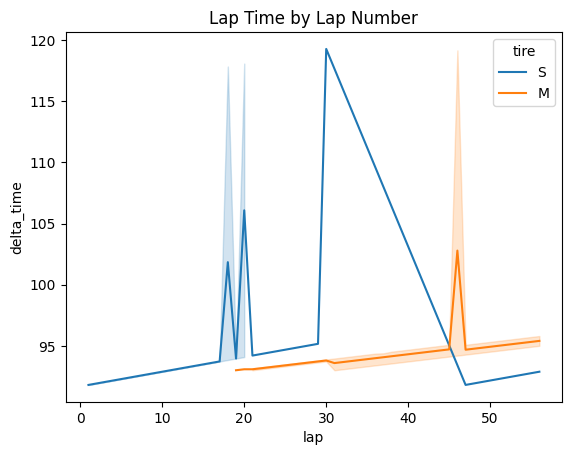

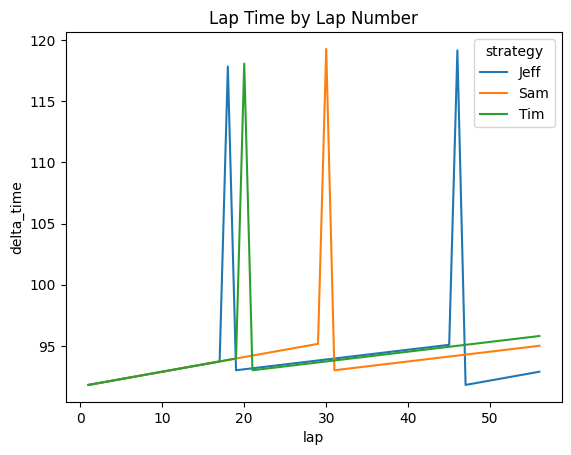

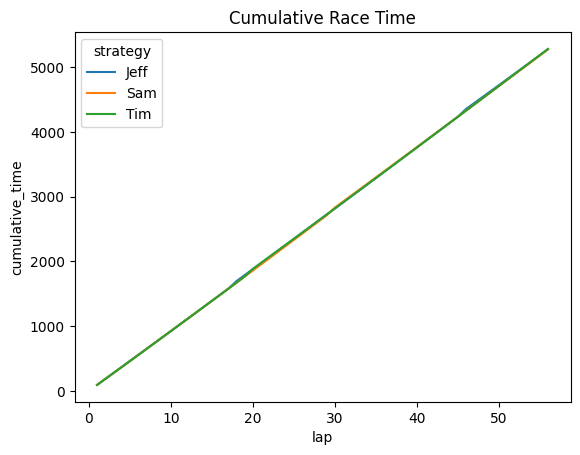

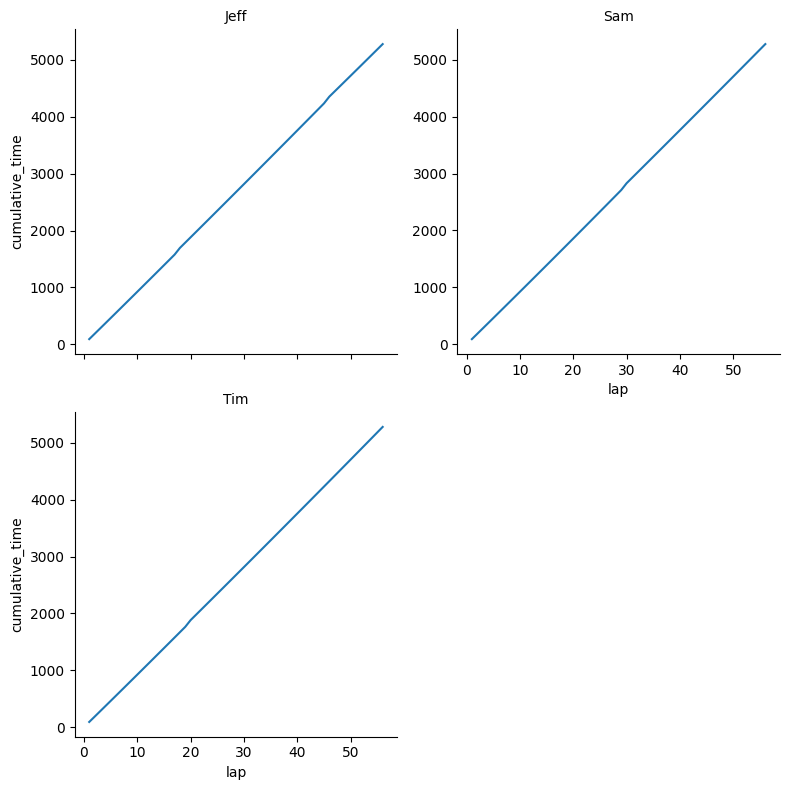

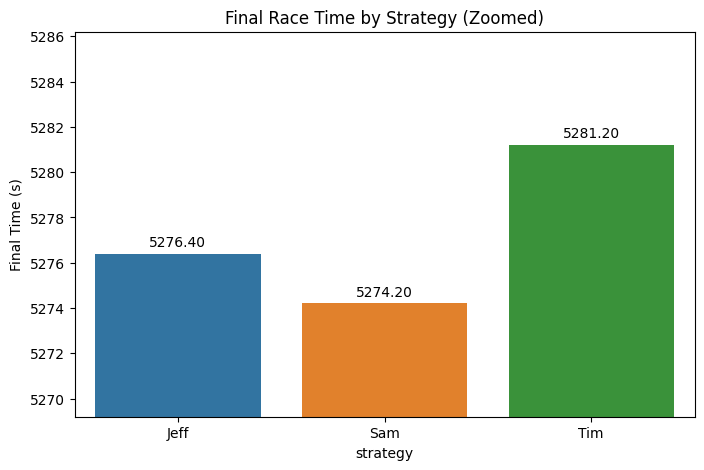

In [2]:
import numpy as np
import pandas as pd

# ------------------------------------------------------------
# 1. Simple lap time model
# ------------------------------------------------------------

"""
Use of an actual race simulator, calling an API was explored, but the following approach was taken, "build my own" to help
provide a basic understanding of the components of lap time.

This is the simplest of models that will allow us to start.  Our pit strategy optimizer will provide this model with
a pit strategy.  Pit strategy is defined as follows,

1. What tire do I start the race with?
2. When do I pit?
3. What compound (tire type) do I switch to?
4. When do I pit again?

An optimal pit strategy will minimize lap times and ultimately result in the fastest race total time.
The race lap and total time simulator will allow us to try different compounds and pit time (which lap to pit on) to compare and visualize results

A stint is defined as the time frame that a particular tire compound in use

lap time = base_lap_time + compound_offset + degradation_rate per lap * tire age in laps, all in seconds

Initially we will only concern ourselves with races run in the dry,
so we don't need to model intermediate or wet tires, only soft, medium and hard compound tires

Soft tires are the fastest since they are sticky, but degrade quickly,
Hard tires degrade at the slowest rate, they last a long time, but are the slowest
Medium tires set in the middle of these two for speed and degradation.

Below Soft = S, Medium = M, Hard = H

A strategy example for Austin TX would be to start on Soft, Pit at Lap 18, then switch to Medium tires to complete the race
The short hand for this would be Soft -> Medium
"""

# To get a handle on the results, we will use the Austin TX venue
AUSTIN_BASE_LAP = 93 # the base lap time for the Austin TX venue is 93 seconds
AUSTIN_PIT_LOSS = 24 # this is the amount of time that is lost in the pit lane entrance, pit, and exit
AUSTIN_TOTAL_LAPS = 56 # total laps for Austin Race
TOTAL_LAPS = AUSTIN_TOTAL_LAPS
BASE_LAP_TIME = AUSTIN_BASE_LAP  # seconds, US Gran Prix Austin TX baseline


TIRE_COMPOUND_OFFSETS = {
    "S": -1.2,   # Softs are fastest, this is the amount per lap where softs improve the baseline performance
    "M": 0.0,    # Medium tire baseline
    "H": +1.5    # Hards are slowest, this is the amount per lap where hard tires add take away from baseline performance
}


TIRE_DEGRADATION_RATES = {
    "S": 0.12,  # Softs degrade fastest,
    "M": 0.08,  # Medium tires degrade at a rate that's between Softs and Hards
    "H": 0.05   # degrade at a rate that is slowest
}

PIT_LOSS = AUSTIN_PIT_LOSS

#define a function that returns the elapsed time for a lap given inputs tire compound and tire age

def lap_time(tire, tire_age):
    return (
        BASE_LAP_TIME
        + TIRE_COMPOUND_OFFSETS[tire]
        + TIRE_DEGRADATION_RATES[tire] * tire_age
    )


# ------------------------------------------------------------
# 2. Simulator
# ------------------------------------------------------------


# now pass in strategy
# a strategy can be starting compound, pit lap, next compound
# when lap count hits pit lap, a pit loss is added, the next lap switches to next compound
# so ("S", 18, "M"), would be a strategy for one stop.
# let's build it for one stop,
# we can define a tuple with a name, first compound, pit stop lap, the next compound

#put in a test to ensure all laps add up to less than the total laps for the race venue
# also extend strategies like below
"""

loop through a strategy stint to ensure lap count does not exceed race total, ultimately decided not to implement
this, since the optimizer will likely be built to test for correct strategies before the simulator is called.
"""

strategy = [
    {"tire": "S", "laps": 18}, # indicates tire compound and laps till pit to change
    {"tire": "M", "laps": 28},
    {"tire": "S", "laps": None}   # final stint
]


#for stint in strategy:
#    print(stint["tire"], stint["laps"])

# now extend the strategy list by building a new list that will bracket stints by lap number
def expand_strategy(strategy, TOTAL_LAPS):

    stints = []
    current_lap = 1

    for stint in strategy:
        tire = stint["tire"]
        laps = stint["laps"]

        if laps is None:
                # final stint goes to end of race
            end_lap = TOTAL_LAPS
        else:
            end_lap = current_lap + laps - 1
        #print(stint)
        stints.append({
            "tire": tire,
            "start": current_lap,
            "end": end_lap
        })
        #print(stints)
        current_lap = end_lap + 1

    return stints
#stints = expand_strategy(strategy, TOTAL_LAPS)
#print(stints)


stints = expand_strategy(strategy, TOTAL_LAPS)
print(stints)
#for stint in strategy:
#    print(stint)
lap_records = []

def total_race_time(strategy_name, strategy, TOTAL_LAPS):
    stints = expand_strategy(strategy, TOTAL_LAPS)
    total = 0
    delta_time = 0

    for stint in stints:
        tire = stint["tire"]
        for lap in range(stint["start"], stint["end"] + 1):
            tire_age = lap - stint["start"]
            delta_time = lap_time(tire, tire_age)
            if (lap == stint["end"] and stint["end"] != TOTAL_LAPS):
                delta_time += PIT_LOSS
            total += delta_time
            #print(f"lap {lap}, tire {tire}, delta_time {delta_time:.3f} cumulative time {total:.3f}")
            lap_records.append({ "strategy": strategy_name,"lap": lap, "tire": tire, "delta_time": delta_time, "cumulative_time": total})

    return total

strategy1 = [
    {"tire": "S", "laps": 18}, # indicates tire compound and laps till pit to change
    {"tire": "M", "laps": 28},
    {"tire": "S", "laps": None}   # final stint
]
strategy2 = [
    {"tire": "S", "laps": 30}, # indicates tire compound and laps till pit to change
    {"tire": "M", "laps": None}
]
strategy3 = [
    {"tire": "S", "laps": 20}, # indicates tire compound and laps till pit to change
    {"tire": "M", "laps": None}
]


total = total_race_time("Jeff", strategy1, TOTAL_LAPS)
total = total_race_time("Sam", strategy2, TOTAL_LAPS)
total_race_time("Tim", strategy3, TOTAL_LAPS)
df_laps = pd.DataFrame(lap_records)
#print(df_laps)
#print(total)


""" Experimentation with plots to review data
"""
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(data=df_laps, x="lap", y="delta_time", hue="tire")
plt.title("Lap Time by Lap Number")
plt.show()

sns.lineplot(data=df_laps, x="lap", y="delta_time", hue="strategy")
plt.title("Lap Time by Lap Number")
plt.show()


sns.lineplot(data=df_laps, x="lap", y="cumulative_time", hue="strategy")
plt.title("Cumulative Race Time")
plt.show()

g = sns.FacetGrid(df_laps, col="strategy", col_wrap=2, height=4, sharey=False)
g.map_dataframe(sns.lineplot, x="lap", y="cumulative_time")
g.set_titles("{col_name}")
plt.show()

df_final = (
    df_laps
    .groupby("strategy", as_index=False)
    .agg(final_time=("cumulative_time", "max"))
)

plt.figure(figsize=(8, 5))



ax = sns.barplot(
    data=df_final,
    x="strategy",
    y="final_time",
    hue="strategy",
    palette="tab10",
    legend=False
)


plt.ylim(df_final["final_time"].min() - 5,
         df_final["final_time"].max() + 5)

plt.title("Final Race Time by Strategy (Zoomed)")
plt.ylabel("Final Time (s)")

# Label ALL bars, not just the first container
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=3)

plt.show()



## 4.2 Linear Tire Model

Model form:
lap_time = a + b * lap_number
or simpler

In [ ]:
from sklearn.linear_model import LinearRegression

X = df[["lap_number"]]
y = df["lap_time"]]

lin_model = LinearRegression().fit(X, y)
lin_model.coef_, lin_model.intercept_

## 4.3 Quadratic Tire Model

Model form:
lap_time = a + b * lap_number + c * lap_number^2

In [ ]:
df["lap_number_sq"] = df["lap_number"]**2
Xq = df[["lap_number", "lap_number_sq"]]

quad_model = LinearRegression().fit(Xq, y)
quad_model.coef_, quad_model.intercept_

## 4.4 Machine Learning Tire Model

Use a more flexible model (Random Forest, Gradient Boosting, etc.)
Include:
- Feature engineering
- Train/validation split

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

features = ["lap_number", "lap_number_sq"]
X_ml = df[features]

X_train, X_test, y_train, y_test = train_test_split(X_ml, y, test_size=0.2)

rf = RandomForestRegressor(n_estimators=200)
rf.fit(X_train, y_train)

# 5. Model Validation & Comparison

## 5.1 Metrics

Compute RMSE, MAE, R² for each model.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate(model, X, y):
    preds = model.predict(X)
    return {
        "RMSE": np.sqrt(mean_squared_error(y, preds)),
        "MAE": mean_absolute_error(y, preds),
        "R2": r2_score(y, preds)
    }

lin_eval = evaluate(lin_model, X, y)
quad_eval = evaluate(quad_model, Xq, y)
rf_eval = evaluate(rf, X_test, y_test)

lin_eval, quad_eval, rf_eval

## 5.2 Visual Validation

Plot predicted vs actual lap times.

In [ ]:
plt.scatter(y_test, rf.predict(X_test), alpha=0.5)
plt.xlabel("Actual Lap Time")
plt.ylabel("Predicted Lap Time")
plt.title("Random Forest: Actual vs Predicted")
plt.show()

# 6. Pit Strategy Optimization

## 6.1 Problem Definition

Goal:
Minimize total race time by choosing optimal pit laps and tire compounds.

Constraints:
- Max stint length
- Tire compound rules
- Degradation model

## 6.2 Optimization Approach

Use simulation or brute-force search to compute total race time for:
- 1-stop strategies
- 2-stop strategies
- 3-stop strategies
- Possibly other strategies imposed by F1 for specific races, like Monaco (2 pit stops required) and Abi Dhabi (max distance imposed on tires)

In [ ]:
def simulate_stint(start_lap, end_lap, model):
    laps = np.arange(start_lap, end_lap+1)
    X_sim = pd.DataFrame({"lap_number": laps, "lap_number_sq": laps**2})
    return model.predict(X_sim).sum()

race_length = df["lap_number"].max()

def simulate_strategy(pit_laps, model):
    total = 0
    stints = [1] + pit_laps + [race_length + 1]
    for i in range(len(stints)-1):
        total += simulate_stint(stints[i], stints[i+1]-1, model)
    return total

## 6.3 Results

Compute race times for all strategies and identify the optimal one.

In [ ]:
strategies = {
    "1-stop": [20],
    "2-stop": [15, 35],
    "3-stop": [12, 25, 38]
}

results = {name: simulate_strategy(stops, rf) for name, stops in strategies.items()}
results

In [ ]:
plt.bar(results.keys(), results.values())
plt.ylabel("Total Race Time (s)")
plt.title("Strategy Comparison")
plt.show()

# 7. Final Results & Insights

Summarize:
- Best-performing tire model
- Optimal pit strategy
- Key findings from the data

# 8. Limitations & Future Work

Discuss:
- Data limitations
- Model assumptions
- Potential improvements

# 9. Appendix

Additional plots, helper functions, raw tables, etc.